In [1]:
%load_ext watermark

In [100]:
%watermark -v -m -p numpy,sklearn,pandas,scipy,matplotlib,statsmodels -g

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.18.1

numpy      : 1.19.2
sklearn    : 0.23.2
pandas     : 0.25.3
scipy      : 1.5.2
matplotlib : 3.3.2
statsmodels: 0.12.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 97f7c957d8bdb2ae97ff130773d39b97d0b4cb18



In [101]:
TQDM_DISABLE = True

### Предположим нам специфицировали задачу.    
### Требуется производить идентификацию для пользователей из директории '150users' и ограничением по времени не превышеющим 10 минут.

In [102]:
import os
import time
import glob
import numpy as np
import pandas as pd

import re
#import random
import pickle
import gc

from tqdm.notebook import tqdm 

import itertools
from collections import Counter
from collections import defaultdict
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split, StratifiedKFold#, GridSearchCV
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, f1_score,

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#from catboost import CatBoostClassifier
#import catboost as cb
#import lightgbm as lgb
#from lightgbm import LGBMClassifier
import xgboost as xgb

In [104]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [105]:
from sklearn import feature_selection

Подготовим окружение, данные, известные параметры

In [106]:
PATH_TO_DATA     = os.path.join('.', 'data')
PATH_TO_DATA_ALL = os.path.join('.', 'data', '150users')
PATH_TO_DATA_OWN = os.path.join('.', 'data_own')
PATH_TO_DATA_ALL_PREP = os.path.join('.', 'data', '150users_prepared')
ANSW = os.path.join('.', 'answers')

In [107]:
filenames_all = [re.findall('\d+', x)[-1] for x in sorted(glob.glob(PATH_TO_DATA_ALL + '/*.csv'))]

In [108]:
WEEK = 7

In [109]:
time.strftime('%H:%M:%S')

'13:46:34'

In [110]:
%%time
# 6 min
if not os.path.isfile(os.path.join(PATH_TO_DATA_ALL_PREP, f'user0006.csv')):
    not_monotonic = 0
    for el in tqdm(filenames_all, desc = u'по всем пользователям', disable = TQDM_DISABLE):
        temp_dataframe = pd.read_csv(os.path.join(PATH_TO_DATA_ALL, f'user{el}.csv'), sep= ',')#, parse_dates=[1]))
        #temp_dataframe.columns = ['target', 'timestamp', 'site']
        temp_dataframe.columns = ['timestamp', 'site']
        temp_dataframe.timestamp = pd.to_datetime(temp_dataframe.timestamp)
        if not temp_dataframe.timestamp.is_monotonic:
            temp_dataframe.sort_values(by = 'timestamp', ascending = True, inplace = True, ignore_index = True)
            not_monotonic += 1
        temp_dataframe['time_diff'] = temp_dataframe.timestamp.diff().shift(-1).apply(lambda x: x.total_seconds())
        temp_dataframe.loc[temp_dataframe.shape[0] - 1, 'time_diff'] = 0.0
        temp_dataframe['target'] = int(el)
        
        temp_dataframe.to_csv(os.path.join(PATH_TO_DATA_ALL_PREP, f'user{el}.csv'), index = False)
        
    print(not_monotonic / len(filenames_all))

Wall time: 0 ns


Длина сессии - чем больше, тем лучше. Ограничимся 20 в виду вычислительных возможностей.    
Размер окна - чем меньше, тем лучше. Ограничимся 5 в виду вычислительных возможностей.    
Временной лимит сессии нам задан - 10 минут = 600 секунд.

In [111]:
sess_len  = 20 #30
wind_size = 5
time_limit = 600

Зафиксируем random_seed для воспроизведения результатов.    
Все оценки будем производить через StratifiedKFold. Зададим его.

In [112]:
rand_seed = 52
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 17)

Словарь будем использовать только по этим пользователям. В противном случае получаем линейно зависимое пространство признаков слишком большой размерности.

In [113]:
def create_load_freq_site_dict(files):
    
    outp_freq_site_dict = dict()
    site_cnt = Counter()

    for idx in tqdm(range(len(files)), desc = 'for all filenames', disable = TQDM_DISABLE):
        #temp_dataframe = pd.read_csv(os.path.join(PATH_TO_DATA_ALL, f'cat{files[idx]}.csv'), header = None, sep= ';')#, parse_dates=[1]))
        #temp_dataframe.columns = ['target', 'timestamp', 'site']
        temp_dataframe = pd.read_csv(os.path.join(PATH_TO_DATA_ALL_PREP, f'user{files[idx]}.csv'), 
                                     #sep= ';', 
                                     usecols = ['site'])#, parse_dates=[1]))
        site_cnt += Counter(temp_dataframe.site.values)
        #rows += round(temp_dataframe.shape[0] / sess_len + 0.499)

    #rows = rows

    for idx, site_dict in enumerate(site_cnt.most_common(), start = 1):
        outp_freq_site_dict[site_dict[0]] = (idx, site_dict[1])    
    
    return outp_freq_site_dict

In [114]:
%%time
# 16 sec
if not os.path.isfile(os.path.join(PATH_TO_DATA_OWN, 'site_freq_150_data.pkl')):
    freq_site_dict = create_load_freq_site_dict(filenames_all)
    pickle.dump(freq_site_dict, open(os.path.join(PATH_TO_DATA_OWN, 'site_freq_150_data.pkl'), 'wb'))
    print(len(freq_site_dict))
else:
    #pkl_name = os.path.join(PATH_TO_DATA_OWN, 'site_freq_full_data.pkl')
    freq_site_dict = pickle.load(open(os.path.join(PATH_TO_DATA_OWN, 'site_freq_150_data.pkl'), 'rb'))

Wall time: 13 ms


Для начала посмотрим точнось при использовании данных только о почещении сайтов при выбранны параметраx.    
Подготовим данные: обучающую, тестовую и проверочную выборки.    
Посмотрим на целевые метки.     
Оценим точность на SGDClassifier.

In [115]:
def prepare_sparse_train_set_window(inp_fnames, inp_sess_len, inp_wind_size, 
                                    inp_freq_site_dict, inp_time_limit = 999999999):
    
    ret_userid_list = []
    # form dataframe names ['site1, site2......site{session_length}']
    #col_names = ['site' + str(n+1) for n in range(inp_sess_len)]

    row_csr  = []
    col_csr  = []
    data_csr = []
        
    row_index = 0
    #early_exit = 0
    
    #print_index = 15
    
    for idx in tqdm(range(len(inp_fnames)), disable = TQDM_DISABLE):
        #print(row_index)
        temp_dataframe = pd.read_csv(os.path.join(PATH_TO_DATA_ALL_PREP, f'user{inp_fnames[idx]}.csv'), 
                                         usecols = ['site', 'time_diff']
                                        )
        userid = inp_fnames[idx]
              
        index = 0

        while index < temp_dataframe.shape[0]:
            condition_index = 0
            total_time = 0
            #new_sess = {('site' + str(n+1)):0 for n in range(inp_sess_len)}
            new_sess = defaultdict(float)
            # determine one current session
            while (condition_index < inp_sess_len) and (total_time < inp_time_limit) and ((index + condition_index) < temp_dataframe.shape[0]):
            #while (condition_index < inp_sess_len) and ((index + condition_index) < temp_dataframe.shape[0]):
                #new_sess['site' + str(condition_index+1)] = inp_freq_site_dict[temp_dataframe.site[index + condition_index]][0]
                new_sess[inp_freq_site_dict[temp_dataframe.site[index + condition_index]][0]] += 1
                total_time += temp_dataframe.time_diff[index + condition_index]
                
                condition_index += 1

            if (condition_index <= inp_wind_size):
                index += (condition_index)
                #early_exit += 1
            else:
                index += inp_wind_size

                
            row_csr += [row_index] * len(new_sess)  # row number in which value is parse
            data_csr+= list(new_sess.values())      # value
            col_csr += list(new_sess.keys())        # column number in which value is parse
            #cnt_csr  = Counter(new_sess.values())
            #row_csr += [row_index] * len(cnt_csr)  # row number in which value is parse
            #data_csr+= list(cnt_csr.values())      # value
            #col_csr += list(cnt_csr.keys())        # column number in which value is parse
            ret_userid_list.append(int(userid))
            row_index += 1

    ret_csr = csr_matrix((data_csr, (row_csr, col_csr)), shape = (max(row_csr)+1, max(col_csr)+1))[:, 1:]
    #print(early_exit)
    
    return ret_csr, np.array(ret_userid_list)

In [116]:
train_data_sparse, targets = prepare_sparse_train_set_window(filenames_all, sess_len, 
                                                             wind_size, freq_site_dict,
                                                             inp_time_limit = time_limit,
                                                            )
X_train, X_valid, y_train, y_valid = train_test_split(train_data_sparse, targets, 
                                                      test_size = 0.3, 
                                                      random_state = rand_seed, stratify = targets,
                                                     )

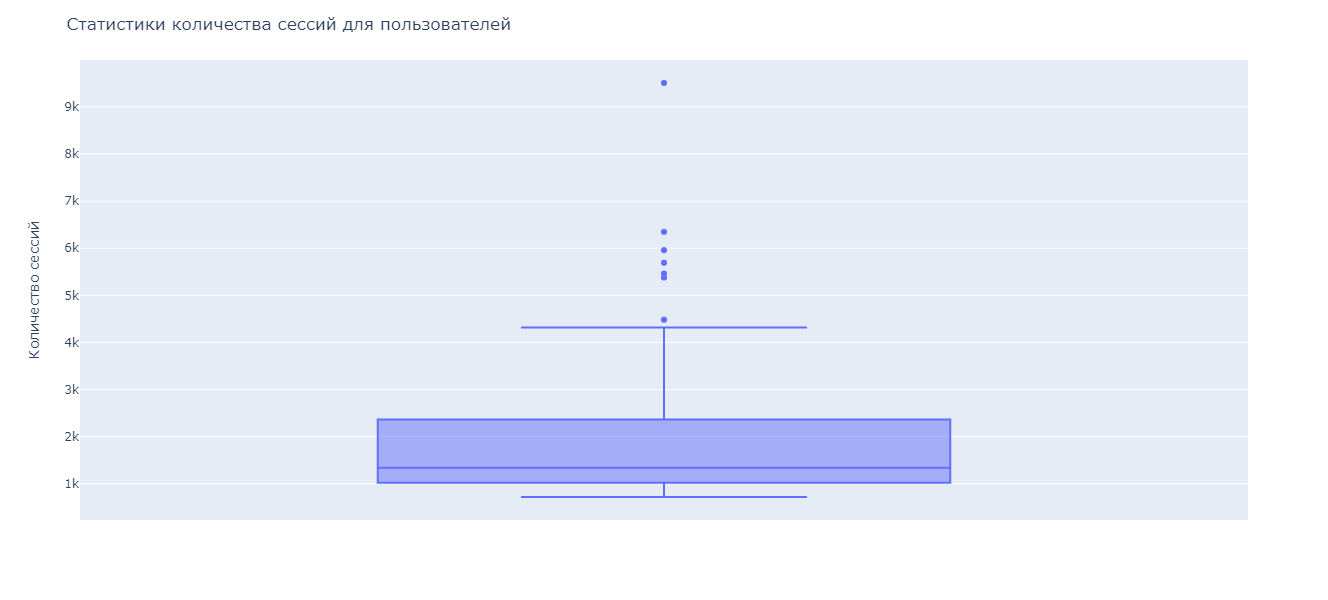

In [201]:
targ_hist = np.bincount(targets)

bin_count = []
for el in targ_hist:
    if el != 0:
        bin_count.append(el)


fig = px.box(y = bin_count)
fig.update_layout(autosize = False,
                  width = 500,
                  height= 600,
                  title = u'Статистики количества сессий для пользователей',
                  yaxis_title = u'Количество сессий',
                 )
fig.show()

Как мы видим, есть некоторое количество пользователей для которых количество сессий аномально много.    
При получении неудовлетворительного результата вероятно стоит произвести undesampling или oversampling.    
На данный момент такая необходимость не очевидна. Продолжаем работу с текущими выборками.

In [137]:
def get_metrics(inp_clf, inp_skf, inp_x_tr, inp_y_tr, inp_x_val, inp_y_val, endmodel = False):
    acc_cv  = []
    acc_val = 0
    f1_cv   = []
    fg1_val = 0
    
    for train_index, test_index in tqdm(inp_skf.split(inp_x_tr, inp_y_tr), 
                                        desc = str(inp_clf).split('(')[0],
                                        disable = TQDM_DISABLE
                                       ):
        iclf = inp_clf
        iclf.fit(inp_x_tr[train_index], inp_y_tr[train_index])
        predicted = iclf.predict(inp_x_tr[test_index])
        acc_cv.append(accuracy_score(inp_y_tr[test_index], predicted))
        f1_cv.append(f1_score(inp_y_tr[test_index], predicted, average = 'macro'))
        
        #print('Score: ', iclf.score(inp_x_tr[test_index], inp_y_tr[test_index]))
    
    if endmodel:
        iclf = inp_clf
        iclf.fit(inp_x_tr, inp_y_tr)

        predicted = iclf.predict(inp_x_val)
        acc_val = accuracy_score(inp_y_val, predicted)
        f1_val.append(f1_score(inp_y_val, predicted, average = 'macro'))
        
        return acc_cv, f1_cv, acc_val, f1_val, iclf

    return acc_cv, f1_cv

Произведем оценку текущей точности с помощью SGDClassifier

In [138]:
%%time
clf_sgd = SGDClassifier(n_jobs = -1, random_state = rand_seed)
sgd_accur_fold, sgd_f1_fold = get_metrics(clf_sgd, skf, X_train, y_train, X_valid, y_valid)
sgd_accur_fold, np.mean(sgd_accur_fold), sgd_f1_fold, np.mean(sgd_f1_fold)


Wall time: 29.4 s


([0.5534416157191958, 0.5474122853710097, 0.5501193861877025],
 0.550324429092636,
 [0.5186648798240004, 0.5203152931176697, 0.5197776380690595],
 0.5195859370035766)

In [21]:
del train_data_sparse
del targets
del X_train
del X_valid
del y_train
del y_valid
del clf_sgd

gc.collect()

86

Попытаемся ее улучшить. Для этого добавим новые признаки.     
    
В виду того, что необходимо производить классификацию на 150 пользователей бинарные признаки нам сильно не помогут.    
Из неиспользуемой информации из данных у нас еще временные метки и последовательность переходов по сайтам.    
Т.к. последовательность переходов повлечет кратное увеличение данных попробуем обойтись только данными о    
временных метках посещения сайтов.     
Действительно: если 2 пользователя похожи по посещенным сайтам, то, например, один может зайти проверить соцсети на    
1 секунду, а дальше работать с почтой, а второй, наоборот, провести много времени в соцсети, а затем на секунду    
проверить почту. В признаках только посещенных сайтов они будут абсолю.тно одинаковы, но не во временных признаках.    

Добавим данные о времени нахождения пользователя на сайте (в секундах), если пользователь повторно зашел на сайт,    
то данные временные интервалы суммируем. Минимальное время нахождения на сайте зададим равным 1 секунде. 'Нормируем'     
эти значения на ограничение по времени, т.к. ни одно посещение не может превышать этого порога, а нормировка     
необходима для ряда алгоритмов.    
Возникает вопрос как поступать с последним сайтом в сессии: возможно, он на секунду вышел за пределы допустимой длины,    
а, возможно, пользователь зашел на него на секунду и следующий посещенный сайт только через неделю. Данный момент      
становится гиперпараметром, рассматривать который в рамках данной работы не станем.    

Так же добавим информацию о дне и часе начала сессии. Стоит обратить внимание, что из 24 часов суток сессии начинаются         
только в 17 часах. Признаки начала сессии в остальне часы необходимо исключить, т.к. они будут нулевыми, что приводит    
к линейной зависимости признаков, что, в свою очередь, вредит линейным методам.

In [91]:
def prepare_sparse_train_set_total(inp_fnames, inp_sess_len, inp_wind_size, 
                                   inp_freq_site_dict, inp_time_limit = 999999999):
    
    ret_userid_list = []

    row_csr  = []
    col_csr  = []
    data_csr = []
        
    row_index = 0
    #early_exit = 0
    
    #print_index = 15
    time_start_idx = len(inp_freq_site_dict)
    
    for idx in tqdm(range(len(inp_fnames)), disable = TQDM_DISABLE):
        temp_dataframe = pd.read_csv(os.path.join(PATH_TO_DATA_ALL_PREP, f'user{inp_fnames[idx]}.csv'), 
                                         usecols = ['timestamp', 'site', 'time_diff'],
                                         parse_dates=['timestamp']
                                    )
        userid = inp_fnames[idx]
              
        index = 0

        while index < temp_dataframe.shape[0]:
            condition_index = 0
            total_time = 0
            
            new_sess = defaultdict(float)
            #add 'dow' and 'hour' as OHE
            dow  = temp_dataframe.timestamp[index].dayofweek
            hour = temp_dataframe.timestamp[index].hour
                
            # all sites + all site times / + 7 days (for hour)
            new_sess[time_start_idx*2 + dow + 1] = 1
            new_sess[time_start_idx*2 + WEEK + hour + 1] = 1
            
            # determine one current session
            while (condition_index < inp_sess_len) and (total_time < inp_time_limit) and ((index + condition_index) < temp_dataframe.shape[0]):
                site_time = temp_dataframe.time_diff[index + condition_index]
                if site_time == 0:
                    site_time += 1
                        
                # normalize on ~[0, 1)
                new_sess[inp_freq_site_dict[temp_dataframe.site[index + condition_index]][0]] += (1/10)
                new_sess[inp_freq_site_dict[temp_dataframe.site[index + condition_index]][0] + time_start_idx] += (site_time/inp_time_limit)
                total_time += temp_dataframe.time_diff[index + condition_index]
                
                condition_index += 1

            if (condition_index <= inp_wind_size):
                index += (condition_index)
                #early_exit += 1
            else:
                index += inp_wind_size

                
            row_csr += [row_index] * len(new_sess)   # row number in which value is parse
            data_csr+= list(new_sess.values())       # value
            col_csr += list(new_sess.keys())         # column number in which value is parse

            ret_userid_list.append(userid)
            row_index += 1

    ret_csr = csr_matrix((data_csr, (row_csr, col_csr)), shape = (max(row_csr)+1, max(col_csr)+1))[:, 1:]
    
    return ret_csr, np.array(ret_userid_list)

Подготовим данные: обучающую, тестовую и проверочную выборки.    

In [23]:
train_data_sparse_v2, targets_v2 = prepare_sparse_train_set_total(filenames_all, sess_len, 
                                                             wind_size, freq_site_dict,
                                                             inp_time_limit = time_limit,
                                                            )
X_train_v2, X_valid_v2, y_train_v2, y_valid_v2 = train_test_split(train_data_sparse_v2, targets_v2, 
                                                                  test_size = 0.3, random_state = rand_seed, 
                                                                  stratify = targets_v2,
                                                                 )

Посмотрим на размерности.

In [24]:
train_data_sparse_v2.shape

(281800, 55625)

Мы ожидаемо получили большое признаковое пространство. При этом явно не все признаки одинаково полезны.     
Идея - выбрать лучший классификатор на текущем пространстве признаков и на его основе произвести отбор признаков.    

Посмотрим на точности классификаторов на текущем пространстве признаков с помощью определенного ранее StratifiedKFold.

SGDClassifier

In [25]:
%%time
# < 1 min
clf_sgd = SGDClassifier(n_jobs = -1, random_state = rand_seed)
sgd_v2_accur_fold, sgd_v2_f1_fold = get_metrics(clf_sgd, skf, X_train_v2, y_train_v2, X_valid_v2, y_valid_v2)
sgd_v2_accur_fold, np.mean(sgd_v2_accur_fold), sgd_v2_f1_fold, np.mean(sgd_v2_f1_fold)


Wall time: 1min 35s


([0.38599933083918847, 0.38416498106550273, 0.39310753881952154],
 0.3877572835747376)

<i>Ожидаемый результат

LogisticRegression 

In [26]:
%%time
# 17+ min
clf_lr = LogisticRegression(n_jobs = -1, random_state = rand_seed)
lr_accur_fold, lr_f1_fold = get_metrics(clf_lr, skf, X_train_v2, y_train_v2, X_valid_v2, y_valid_v2)
lr_accur_fold, np.mean(lr_accur_fold), lr_f1_fold, np.mean(lr_f1_fold)


Wall time: 12min 22s


([0.052498707302977766, 0.05380743083965751, 0.05430930908095448],
 0.05353848240786325)

<i>Ожидаемый результат

KNeighborsClassifier

In [27]:
%%time
# 15+ min
#clf_knn = KNeighborsClassifier(n_neighbors=50, n_jobs=-1)
clf_knn = KNeighborsClassifier(n_jobs = -1)
kn_accur_fold, kn_f1_fold = get_metrics(clf_knn, skf, X_train_v2, y_train_v2, X_valid_v2, y_valid_v2)
kn_accur_fold, np.mean(kn_accur_fold), kn_f1_fold, np.mean(kn_f1_fold)


Wall time: 14min 39s


([0.7027101012866137, 0.7025839125211017, 0.7014584885860721],
 0.7022508341312625)

<i>Ожидал лучшего результата. Возможно сказывается размерность пространства.

LinearSVC

In [28]:
%%time
# 36+ min
clf_svc = LinearSVC(random_state = rand_seed)
svc_accur_fold, svc_f1_fold = get_metrics(clf_svc, skf, X_train_v2, y_train_v2, X_valid_v2, y_valid_v2)
svc_accur_fold, np.mean(svc_accur_fold), svc_f1_fold, np.mean(svc_f1_fold)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




Wall time: 2h 48min 30s


([0.6593971469416309, 0.6578102900247897, 0.6580232080665521],
 0.6584102150109908)

<i>Ожидаемый достойный результат.

RandomForestClassifier

In [29]:
%%time 
# 1 hour 15+ min
clf_rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = rand_seed,)
rf_accur_fold, rf_f1_fold = get_metrics(clf_rf, skf, X_train_v2, y_train_v2, X_valid_v2, y_valid_v2)
rf_accur_fold, np.mean(rf_accur_fold), rf_f1_fold, np.mean(rf_f1_fold)


Wall time: 28min 24s


([0.8297594062718617, 0.8287530606968503, 0.8275211777409396],
 0.828677881569884)

<i>Лучший результат

XGBoost

In [30]:
xgb_params = {
    'tree_method':'gpu_hist',
    "objective": "multi:softmax",
    #"eta": 0.3,
    "num_class": 150,
    #"max_depth": 10,
    "eval_metric": "mlogloss",
    #"verbosity": 2,
}

XGBoost необходимы классы типа int в пределах от 0 до len(classes) - 1.     
Подготовим.

In [31]:
remap = {el:idx for idx, el in enumerate(set(y_train_v2))}

y_tr_v2 = [remap[x] for x in y_train_v2]
y_val_v2 = [remap[x] for x in y_valid_v2]
Dtrain = xgb.DMatrix(X_train_v2, y_tr_v2)
Dtest = xgb.DMatrix(X_valid_v2)

In [32]:
%%time
# 40+ min
model_xgb = xgb.train(xgb_params, Dtrain, 
                   #num_boost_round = 50,
                   #early_stopping_rounds = 10, 
                 )
pred = model_xgb.predict(Dtest)
accuracy_score(y_val_v2, pred), f1_score(y_val_v2, pred, average = 'macro')

Wall time: 1h 5min 7s


0.5348355807901585

<i>Неожидано слабый результат

In [33]:
time.strftime('%H:%M:%S')

'03:54:37'

Как видим лучший результат показал RandomForest.    
Дальше работаем с ним.

In [34]:
del clf_sgd
del clf_lr
del clf_knn
del clf_svc
del model_xgb
del y_tr_v2
del y_val_v2
del Dtrain
del Dtest

gc.collect()

430

In [35]:
del X_train_v2
del X_valid_v2
del y_train_v2
del y_valid_v2

gc.collect()

22

Уменьшим размерность пространства признаков.

Для начала обучим RandomForestClassifier на всей выборке объектов для более корректного определения полезности признаков.

In [42]:
%%time
clf_rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
clf_rf.fit(train_data_sparse_v2, targets_v2)

Wall time: 23min 25s


RandomForestClassifier(n_jobs=-1)

In [43]:
del train_data_sparse_v2
del targets_v2

gc.collect()

Т.к. классификатор у нас уже обучен, отбор признаков будем проводить на основе их полезности через sklearn.feature_selection.SelectFromModel.

Зададим варианты порога полезности признаков и посмотрим на изменение точности модели при отборе признаков по таким порогам.

In [97]:
# params for select features
thres = ['mean', 1e-5, 1e-6, 'median']

In [81]:
def check_useful(inp_list):
    
    site = 0
    sites = len(freq_site_dict)
    timings = 0
    dow = 0
    hour = 0
    for idx, el in enumerate(inp_list):
        if idx < (sites) and el == True:
            site += 1
        elif (idx >= sites) and (idx < (sites*2)) and el == True:
            timings += 1
        elif (idx >= sites*2) and (idx < sites*2 + 7) and el == True:
            dow  += 1
        elif (idx >= sites*2+7) and el == True:
            hour += 1
            
    print('useful sites: ' + str(site) + ', timings: ' + str(timings) +\
          ', dayofweek: ' + str(dow) + ', hours: ' + str(hour))
    
    return

In [83]:
%%time
thres_acc = []
thres_f1  = []
for el in thres:
    # select features
    features = feature_selection.SelectFromModel(clf_rf, prefit=True, threshold=el)
    print('feature importance threshold: ' + str(el) + ', useful features: ' + str(sum(features.get_support())))
    check_useful(features.get_support())
    
    # create 'new' freq_site_dict
    idx = 1
    freq_site_low_dict = defaultdict(lambda: (0, 0.0))
    for useful, ftr in zip(features.get_support(), freq_site_dict.keys()):
        if useful:
            freq_site_low_dict[ftr] = (idx, 0)
            idx += 1
    
    # create new train/test data
    train_data_sparse_v3, targets_v3 = prepare_sparse_train_set_total(filenames_all, sess_len, 
                                                             wind_size, freq_site_low_dict,
                                                             inp_time_limit = time_limit,
                                                            )
    X_train_v3, X_valid_v3, y_train_v3, y_valid_v3 = train_test_split(train_data_sparse_v3, targets_v3, 
                                                                      test_size = 0.3, 
                                                                      random_state = rand_seed, stratify = targets_v3,
                                                                     )
    
    # evaluate results
    clf_rf_v3 = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = rand_seed)
    rf_v3_accur_fold, rf_v3_f1_fold = get_metrics(clf_rf_v3, skf, X_train_v3, y_train_v3, X_valid_v3, y_valid_v3)
    thres_acc.append(np.mean(rf_v3_accur_fold))
    thres_f1.append(np.mean(rf_v3_f1_fold))
    
    print(rf_v3_accur_fold, np.mean(rf_v3_accur_fold), rf_v3_f1_fold, np.mean(rf_v3_f1_fold), '\n\n')


Treshold 1e-06, useful features 34044
useful sites: 17029, timings: 16991, dayofweek: 7, hours: 17



[0.8288317060559054, 0.8272474259729594, 0.825391997323316] 0.8271570431173937
Wall time: 24min 46s


In [46]:
time.strftime('%H:%M:%S')

'12:17:24'

In [58]:
features = feature_selection.SelectFromModel(clf_rf, prefit = True, threshold = 1e-6)
print(sum(features.get_support()))

34044


ВЫБОР ПОРОГА, ОБУЧЕНИЕ НА ЗАНИЖЕННОМ ПОРОГЕ

In [87]:
%%time 
#n_estimators=100,
clf_rf_200 = RandomForestClassifier(n_estimators = 200, n_jobs = -1, random_state = rand_seed)
rf_accur_fold, rf_accur, rf_f1_fold, rf_f1, clf_rf_200 = 
                                      get_metrics(clf_rf_200, skf, X_train_v3, y_train_v3, 
                                                  X_valid_v3, y_valid_v3, endmodel = True,
                                                  )
rf_accur_fold, rf_accur, rf_f1_fold, rf_f1


Wall time: 2h 10min 22s


([0.8352799829668157, 0.834136845467127, 0.8325855854485726],
 0.8791932812869647)

In [85]:
rf_accur_fold

[0.8297594062718617, 0.8287530606968503, 0.8275211777409396]

In [59]:
features = feature_selection.SelectFromModel(clf_rf, prefit = True, threshold = 1e-6)
print(sum(features.get_support()))

34044


### Выводы:    
- удалось реализовать идентификацию пользователя из заданных 150 по последовательности посещенных им сайтов в течении времени,     
  не превышающем 10 минут;
- достигнутые значения метрик: accuracy, f1_score(macro);


### Возможные пути улучшения:
- добавление дополнительных признаков с учетом порядка посещенных сайтов (n-граммы) с последующим их отбором по полезности;
- обучение 150 различных классификаторов для каждого пользователя в отдельности (one-vs-rest);
- дополнительная оптимизация гиперпараметров выбранного алгоритма;
- использование ансамбля различных алгоритмов;
- получение дополнительных данных по поведению пользователя (геолокация, устройства и т.п.);

### trash below

Произведем оценку точности по пользователям.

In [121]:
from sklearn.metrics import confusion_matrix

In [120]:
#user_accuracy = {el:0 for el in set(targets)}

In [ ]:
#for el in tergets_v3:
    

In [125]:
predicted = clf_sgd.predict(X_valid)
#predicted = clf_rf_200.predict(X_valid)

In [127]:
predicted, y_valid

(array([ 575,  361,   89, ..., 2408,  238,  269]),
 array([ 575,  254, 1054, ...,  298,  238,  269]))

In [181]:
matrix = confusion_matrix(y_valid, predicted)
all_accuracy = matrix.diagonal() / matrix.sum(axis = 0) #axis = 0
all_accuracy2 = matrix.diagonal() / matrix.sum(axis = 1) #axis = 0

In [184]:
(np.mean(all_accuracy) + np.mean(all_accuracy2)) / 2

0.54204516644158

In [173]:
accuracy_score(y_valid, predicted)

0.5498107404778803

In [174]:
np.mean(all_accuracy)

0.5746306952019807

In [175]:
per30 = np.percentile( all_accuracy, 30)
print(sum([True if el < per30 else False for el in all_accuracy ]))

45


In [176]:
for user, accuracy_point in zip(set(targets), all_accuracy):
    if accuracy_point < per30:
        print(user, accuracy_point)

16 0.4263888888888889
28 0.3705533596837945
1054 0.26614173228346455
33 0.4613466334164589
561 0.25833333333333336
563 0.38035087719298244
564 0.24855491329479767
570 0.3306613226452906
575 0.22128851540616246
600 0.23366834170854273
100 0.10421836228287841
105 0.37799043062200954
106 0.20944558521560575
120 0.4678362573099415
126 0.3424657534246575
128 0.38362068965517243
138 0.20437956204379562
653 0.47058823529411764
2191 0.4673684210526316
665 0.3156862745098039
158 0.4755822689706987
677 0.35260115606936415
172 0.21328671328671328
203 0.46629213483146065
207 0.43388429752066116
722 0.31496881496881496
223 0.2655086848635236
1248 0.23504273504273504
236 0.4172661870503597
240 0.236
1267 0.24250681198910082
756 0.4403409090909091
246 0.09005726184279021
261 0.39896373056994816
1798 0.453027139874739
269 0.25225225225225223
1299 0.389937106918239
298 0.47345132743362833
339 0.4335154826958106
340 0.2292134831460674
342 0.0646900269541779
351 0.2661290322580645
411 0.4774436090225564


In [177]:
user_accuracy = {el:0 for el in set(targets)}
user_total = {el:list(y_valid).count(el) for el in set(targets)}

for el_true, el_pred in zip(y_valid, predicted):
    if el_true == el_pred:
        user_accuracy[el_true] += (1 / user_total[el_true])

In [178]:
user_accuracy

{515: 0.3169291338582672,
 6: 0.8688271604938043,
 13: 0.6072423398328692,
 15: 0.5758835758835739,
 16: 0.8032915360501409,
 1040: 0.764705882352939,
 533: 0.5869918699187,
 28: 0.5836501901140672,
 1054: 0.6237623762376245,
 31: 0.4698544698544699,
 33: 0.5480314960629901,
 39: 0.5576208178438754,
 46: 0.6842105263157904,
 49: 0.661596958174903,
 50: 0.3641732283464561,
 561: 0.49194547707559577,
 563: 0.36102236421725137,
 53: 0.4772727272727294,
 564: 0.5689655172413802,
 568: 0.29859154929577436,
 569: 0.5958631662688999,
 570: 0.7541899441340825,
 573: 0.2859025032938088,
 575: 0.5322415557830106,
 576: 0.16969696969696996,
 65: 0.3093525179856114,
 66: 0.2063492063492067,
 2625: 0.6203208556149751,
 580: 0.627211714460028,
 2118: 0.6546052631578929,
 583: 0.7159887798036252,
 584: 0.6079418344519083,
 82: 0.23417721518987314,
 85: 0.2852760736196321,
 600: 0.6513409961685861,
 89: 0.6467780429594281,
 603: 0.4481927710843386,
 92: 0.44580777096114643,
 605: 0.7936893203883493,
 

In [179]:
np.mean(list(user_accuracy.values()))

0.5094596376811793

In [180]:
max(user_accuracy.values())

0.9056785370548575